In [1]:
from docx import Document
from docx.shared import Mm, Pt, Cm
from docx.enum.text import WD_LINE_SPACING, WD_ALIGN_PARAGRAPH, WD_UNDERLINE
from docx.enum.table import WD_CELL_VERTICAL_ALIGNMENT, WD_TABLE_ALIGNMENT

import numpy as np
import json
import os
from random import randrange
from datetime import timedelta, datetime

from write import write_pdf_linux, write_jpg

from pdf2jpg import pdf2jpg
import pypdfium2 as pdfium

import pymorphy2
from faker import Faker

# Generate functions

In [115]:
# формат json {'words': [], 'bbox': [[], []]}

def generate_mail_data():
    def random_date(start, end):
        """
        This function will return a random datetime between two datetime 
        objects.
        """
        delta = end - start
        int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
        random_second = randrange(int_delta)
        return start + timedelta(seconds=random_second)
    
    fake = Faker('ru_RU')
    
    # logo
    logo = os.path.join('samples', 'logo', np.random.choice(os.listdir(os.path.join('samples', 'logo'))))
    date = random_date(datetime.strptime('01.01.2000', '%d.%m.%Y'), datetime.strptime('01.11.2023', '%d.%m.%Y')).strftime('%d.%m.%Y')
    mail_num = fake.postcode()
    
    # header
    with open(os.path.join('samples', 'responsible.json'), 'r', encoding='utf-8') as f:
        resp = json.load(f)
        
    morph = pymorphy2.MorphAnalyzer(lang='ru')
    header_sample = resp[np.random.choice(np.arange(len(resp)))]
    
    title = ''
    if np.random.random() > 0.5:
        title_tokens = header_sample[4].split(' ')
        if 'ADJF' in morph.parse(title_tokens[0])[0].tag:
            title_tokens[0] = morph.parse(title_tokens[0])[0].inflect({'datv'}).word
            title_tokens[1] = morph.parse(title_tokens[1])[0].inflect({'datv'}).word
        else:
            title_tokens[0] = morph.parse(title_tokens[0])[0].inflect({'datv'}).word
        title = ' '.join(title_tokens)

    adresat_tokens = header_sample[1:4]
    adresat_part = ['Surn', 'Name', 'Patr']
    ref_name = header_sample[1:4]
    gen = 'male'
    for i in range(len(adresat_tokens)):
        if len(adresat_tokens[i]) > 0:
            most_likely = morph.parse(adresat_tokens[i])[0]
            for candidat in morph.parse(adresat_tokens[i]):
                if adresat_part[i] in candidat.tag or 'nomn' in candidat.tag: # 'Surn' 'Name', 'Patr'
                    most_likely = candidat
                    if {adresat_part[i], 'nomn'} in candidat.tag:
                        break
            word_datv = most_likely.inflect({'datv', 'sing'})
    
            if word_datv:
                adresat_tokens[i] = word_datv.word
                ref_name[i] = most_likely.inflect({'nomn', 'sing'}).word
            if i == 0:
                gen = 'male' if 'masc' in most_likely.tag else 'female'
    
    adresat = ' '.join(adresat_tokens)
    
    org = fake.company()
    while any([stop_word in org.lower() for stop_word in ['инк','лтд']]):
        org = fake.company()
    
    header = title.capitalize() + ' ' + org + ' ' + adresat.title() 
    
    # reference
    has_ref = True if np.random.random() > 0.5 else False
    reference_text = ''
    if has_ref:
        reference_text = ('Уважаемый ' if gen == 'male' else 'Уважаемая ') + ' '.join(ref_name).title().strip() + '!'
        
    # main_text
    main_text_samples = [["""Мы обращаемся к вам от имени Название вашей организации с важным сообщением. Мы хотели бы поделиться информацией о нашей компании и ее деятельности.
Ваша организация является ведущей в своей отрасли и специализируется на указать область деятельности. Мы гордимся нашими достижениями и стремимся к постоянному развитию и инновациям.
Мы предлагаем широкий спектр продуктов и услуг, которые удовлетворяют потребности наших клиентов. Наша команда состоит из высококвалифицированных специалистов, которые работают вместе, чтобы обеспечить высокое качество и превосходное обслуживание.
Спасибо за ваше внимание и поддержку. Мы надеемся на возможность сотрудничества с вами."""], 
                [['Сообщаем Вам о том, что 15.07.2023 года в 10:00 состоится онлайн-конференция «Современные технологии и методы проектирования в машиностроении».'],
                ['Программа конференции:'],
                ['1. Введение в тему.'],
                ['2. Инновационные технологии проектирования машин.'],
                ['3. Применение современных CAD/CAM систем при проектировании механических конструкций.'],
                ['Для участия в конференции необходимо направить заявку на электронную почту адрес до 12.07.2023 года.']]]
    main_text = main_text_samples[np.random.choice(range(len(main_text_samples)))]
    
    # creator
    footer_sample = resp[np.random.choice(np.arange(len(resp)))]
    creator_title = footer_sample[4]
    creator_name = footer_sample[1] + ' '
    for tok in footer_sample[2:4]:
        if bool(tok):
            creator_name += tok[0] + '. '
    
    creator_name = creator_name.strip()
    
    # signature
    signature = os.path.join('samples', 'signature', np.random.choice(os.listdir(os.path.join('samples', 'signature'))))
    
    # executor
    
    contact_type = np.random.choice(['mail', 'phone'])
    executor_name = fake.name()
    contact = fake.ascii_free_email() if contact_type == 'mail' else fake.phone_number()

    return logo, date, mail_num, header, has_ref, reference_text, main_text, creator_title, creator_name, signature, executor_name, contact


In [116]:
out_dir = 'letters_out'

def generate_doc(filename): # без разрешения файла
    logo, date, mail_num, header, has_ref, reference_text, main_text, creator_title, creator_name, signature, executor_name, contact = generate_mail_data()
    document = Document()
    
    # text_tokens = [header, date, mail_num, reference_text, main_text, creator_title, creator_name, executor_name, contact]
    # with open(os.path.join(out_dir, 'txt', f'{filename}.txt'), 'w') as f:
    #     for tok in text_tokens:
    #         if tok == text_tokens[-1]:
    #             f.write(tok)
    #         else:
    #             for word in tok.split(' '):
    #                 if len(word) > 0:
    #                     f.write(word + '\n')
                    
    # General doc settings
    style = document.styles['Normal']
    font = style.font
    p_format = style.paragraph_format
    font.name = "Times New Roman" # consts.font_name
    font.size = Pt(14) # consts.font_size
    p_format.line_spacing_rule = WD_LINE_SPACING.ONE_POINT_FIVE # consts.line_spacing
    
    for section in document.sections:
        section.top_margin =  Mm(20) # consts.top_margin
        section.bottom_margin = Mm(20) # consts.bottom_margin
        section.left_margin = Mm(30) # consts.left_margin
        section.right_margin = Mm(15) # consts.right_margin
        
    # Header
    table = document.add_table(rows=1, cols=2)
    for cell in table.rows[0].cells:
        tc = cell._element.tcPr
        tc.left = None
        tc.top = None
        tc.right = None
        tc.bottom = None
        cell.vertical_alignment = WD_CELL_VERTICAL_ALIGNMENT.TOP
        cell.paragraphs[0].alignment = WD_TABLE_ALIGNMENT.LEFT
    
    table.cell(0, 0).paragraphs[0].add_run().add_picture(logo, Mm(40), Mm(40))
    run = table.cell(0, 0).add_paragraph().add_run(f'{date}  №  {mail_num} ')
    run.font.underline = True
    run.font.size = Pt(10)
    run = table.cell(0, 0).add_paragraph().add_run(f'на  №        от        .')
    run.font.underline = True
    run.font.size = Pt(10)
    
    header_cell = table.cell(0, 1)
    header_cell.paragraphs[0].add_run(header)
    header_cell.paragraphs[0].alignment = WD_TABLE_ALIGNMENT.RIGHT
    
    for c0, c1 in zip(table.columns[0].cells, table.columns[1].cells):
        c0.width = Cm(10.5)
        c1.width = Cm(7.0)
    
    # Reference
    if has_ref:
        ref = document.add_paragraph()
        ref.alignment = 1
        ref.add_run(reference_text)
    
    # Main part
    main = document
    
    # main.add_run(main_text[0])
    for main_p in range(0, len(main_text)):
        par = main.add_paragraph()
        
        main_fmt = par.paragraph_format
        main_fmt.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
        main_fmt.first_line_indent = Cm(1.25)
        
        par.add_run(main_text[main_p])
    
    # Footer
    foot_table = document.add_table(rows=2, cols=3)
    
    for cell in foot_table.rows[0].cells:
        tc = cell._element.tcPr
        tc.left = None
        tc.top = None
        tc.right = None
        tc.bottom = None
        cell.vertical_alignment = WD_CELL_VERTICAL_ALIGNMENT.TOP
        cell.paragraphs[0].alignment = WD_TABLE_ALIGNMENT.LEFT
    
    for c0, c1, c2 in zip(foot_table.columns[0].cells, foot_table.columns[1].cells, foot_table.columns[2].cells):
        c0.width = Cm(10.0)
        c1.width = Cm(3.0)
        c2.width = Cm(4.0)
    
    foot_table.cell(0, 0).paragraphs[0].add_run(creator_title)
    foot_table.cell(0, 0).paragraphs[0].alignment = WD_TABLE_ALIGNMENT.LEFT
    
    foot_table.cell(0, 1).paragraphs[0].add_run().add_picture(signature, Mm(30), Mm(20))
    foot_table.cell(0, 1).paragraphs[0].alignment = WD_TABLE_ALIGNMENT.RIGHT
    
    foot_table.cell(0, 2).paragraphs[0].add_run(creator_name)
    foot_table.cell(0, 2).paragraphs[0].alignment = WD_TABLE_ALIGNMENT.RIGHT
    
    fmt = foot_table.cell(1, 0).paragraphs[0].paragraph_format
    fmt.line_spacing_rule = WD_LINE_SPACING.SINGLE
    run = foot_table.cell(1, 0).paragraphs[0].add_run(executor_name)
    foot_table.cell(1, 0).paragraphs[0].alignment = WD_TABLE_ALIGNMENT.LEFT
    run.font.size = Pt(10)
    run = foot_table.cell(1, 0).add_paragraph().add_run(contact)
    foot_table.cell(1, 0).paragraphs[0].alignment = WD_TABLE_ALIGNMENT.LEFT
    run.font.size = Pt(10)
    
      
    document.save(os.path.join(out_dir, 'doc', f'{filename}.docx'))

# write_pdf_linux('letter.docx', '.', 0)
# write_jpg('.', 0)

In [124]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
import pdfminer
import os
import pandas as pd
import pdf2image
import numpy as np
import PIL
from PIL import Image
import io
from pathlib import Path
import json

def generate_pdf(docx_path, filename):
    convert(docx_path, os.path.join(out_dir, 'pdf', f'{filename}.pdf'))

def generate_jpg(pdf_path, filename):
    pdf = pdfium.PdfDocument(pdf_path)

    n_pages = len(pdf)
    
    for page_num in range(n_pages):
        page = pdf.get_page(page_num)
        pil_image = page.render(
            scale=1,
            rotation=0,
            crop=(0, 0, 0, 0),
            # colour=(255, 255, 255, 255),
            # annotations=True,
            # greyscale=False,
            # optimise_mode=pdfium.OptimiseMode.NONE
        ).to_pil()
        pil_image.save(os.path.join(out_dir, 'jpg', f'{filename}_{page_num}.png'))
    
    pdf.close()

def get_word_boxes(img_arr, white_px_count=5, white_px_thresh=254):
    img_arr = img_arr[:-2, :, :]
    px_sum = img_arr.mean(axis=(0, 2))
    word_borders = []
    white_count = 0
    for i, col in enumerate(px_sum):
        if col > white_px_thresh:
            white_count += 1
        else:
            if i - white_count <= 0:
                word_borders.append(i)
            elif white_count > white_px_count:
                word_borders.append(i - white_count)
                word_borders.append(i)
            white_count = 0
        if i == len(px_sum) - 1:
            word_borders.append(i - white_count)

    return word_borders

def generate_jpg_and_layout(pdf_path, filename):
    # pdf_path = 'letters_out/pdf/0.pdf' #Path.cwd()/"Git From Bottom Up.pdf"
    
    
    # PART 1: GET LTBOXES COORDINATES IN THE IMAGE ----------------------
    # Open a PDF file.
    fp = open(pdf_path, 'rb')
    
    # Create a PDF parser object associated with the file object.
    parser = PDFParser(fp)
    
    # Create a PDF document object that stores the document structure.
    # Password for initialization as 2nd parameter
    document = PDFDocument(parser)
    
    # Check if the document allows text extraction. If not, abort.
    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed
    
    # Create a PDF resource manager object that stores shared resources.
    rsrcmgr = PDFResourceManager()
    
    # Create a PDF device object.
    device = PDFDevice(rsrcmgr)
    
    # BEGIN LAYOUT ANALYSIS
    # Set parameters for analysis.
    laparams = LAParams()
    
    # Create a PDF page aggregator object.
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    
    boxes = []
    words = []
    # here is where i stored the data
    boxes_line_data = []
    page_sizes = []
    
    def parse_obj(lt_objs, verbose = 0):
        # loop over the object list
        for obj in lt_objs:
            # if it's a textbox, print text and location
            if isinstance(obj, pdfminer.layout.LTTextBoxHorizontal):
                if verbose >0:
                    print("%6d, %6d, %s" % (obj.bbox[0], obj.bbox[1], obj.get_text()))
                data_dict = {
                    "startX":round(obj.bbox[0]),
                    "startY":round(obj.bbox[1]),
                    "endX":round(obj.bbox[2]),
                    "endY":round(obj.bbox[3]),
                    "text":obj.get_text()}
                boxes_line_data.append(data_dict)
            # if it's a container, recurse
            elif isinstance(obj, pdfminer.layout.LTFigure):
                parse_obj(obj._objs)
    
    # loop over all pages in the document
    for page in PDFPage.create_pages(document):
        # read the page into a layout object
        interpreter.process_page(page)
        layout = device.get_result()
        # extract text from this object
        parse_obj(layout._objs)
        mediabox = page.mediabox
        mediabox_data = {"height":mediabox[-1], "width":mediabox[-2]}
        page_sizes.append(mediabox_data)
    
    # PART 2: NOW GET PAGE TO IMAGE -------------------------------------
    firstpage_size = page_sizes[0]
    firstpage_image = pdf2image.convert_from_path(pdf_path, poppler_path=r'poppler-23.11.0\Library\bin')[0] # without 'size=...'
    #show first page with the right size (at least the one that pdfminer says)
    # firstpage_image.show()
    firstpage_image.save(os.path.join(out_dir, 'jpg', f'{filename}.jpg'))
    
    # the magic numbers
    dpi = 200/72
    vertical_shift = 5 # I don't know, but it's need to shift a bit
    page_height = int(firstpage_size["height"] * dpi)
    
    # loop through boxes (we'll process only first page for now)
    for i, _ in enumerate(sorted(boxes_line_data, key=lambda x: x['startY'])):
    
        #first box data
        startX, startY, endX, endY, text = boxes_line_data[i].values()
    
        # correction PDF --> PIL
        startY = page_height - int(startY * dpi) - vertical_shift
        endY   = page_height - int(endY   * dpi) - vertical_shift
        startX = int(startX * dpi)
        endX   = int(endX   * dpi)
        startY, endY = endY, startY 
    
        # turn image into array
        image_array = np.array(firstpage_image)
        # get cropped box
        box = image_array[startY:endY,startX:endX,:]
        if i == len(boxes_line_data) - 2:
            word_borders = get_word_boxes(box, white_px_count=3, white_px_thresh=252)
            for ix, word in zip(range(0, len(word_borders)-1, 2), [word for word in text.split(' ') if len(word) > 0]):
                if word_borders[ix+1] - word_borders[ix] > 3:
                    boxes.append([[startX+word_borders[ix], startY],
                                  [startX+word_borders[ix+1], endY]])
                    words.append(word)
        elif i == len(boxes_line_data) - 1:
            boxes.append([[startX, startY],
                          [endX, endY]])
            words.append(text)
        else:
            word_borders = get_word_boxes(box, white_px_count=7)
            for ix, word in zip(range(0, len(word_borders)-1, 2), [word for word in text.split(' ') if len(word) > 0]):
                if word_borders[ix+1] - word_borders[ix] > 3:
                    boxes.append([[startX+word_borders[ix], startY],
                                  [startX+word_borders[ix+1], endY]])
                    words.append(str(word))
        
        # Close PDF file
        fp.close()
        
        json_data = {'img_path': f'{filename}.jpg',
                     'boxes': boxes,
                     'words': words,
                    }
        with open(os.path.join(out_dir, 'json', f'{filename}.json'), 'w', encoding='utf-8') as f:
            json.dump(json_data, f)
        # if i == len(boxes_line_data) - 2:
        #     convert2pil_image = PIL.Image.fromarray(box)
        #     png = "crop_" + str(i) + ".png"
        #     convert2pil_image.save(png)

# Generate mail

In [125]:
import sys
import os
import comtypes.client
from docx2pdf import convert
from tqdm import tqdm
# filename = 0

# ADR (Adresat)
# ORG (Organization)
# JT (Job Title)
# DR (Date recieved)
# DS (Date sent)
# O (Other)
# SND (Sender)
# EXR (Executor)
# PHN (Phone number)

for filename in tqdm(range(10)):
    generate_doc(filename)
    generate_pdf(os.path.join(out_dir, 'doc', f'{filename}.docx'), filename)
    # generate_jpg(os.path.join(out_dir, 'pdf', f'{filename}.pdf'), filename)
    generate_jpg_and_layout(os.path.join(out_dir, 'pdf', f'{filename}.pdf'), filename)
    # coords, tokens = get_word_coords(os.path.join(out_dir, 'pdf', f'{filename}.pdf'))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.90s/it]


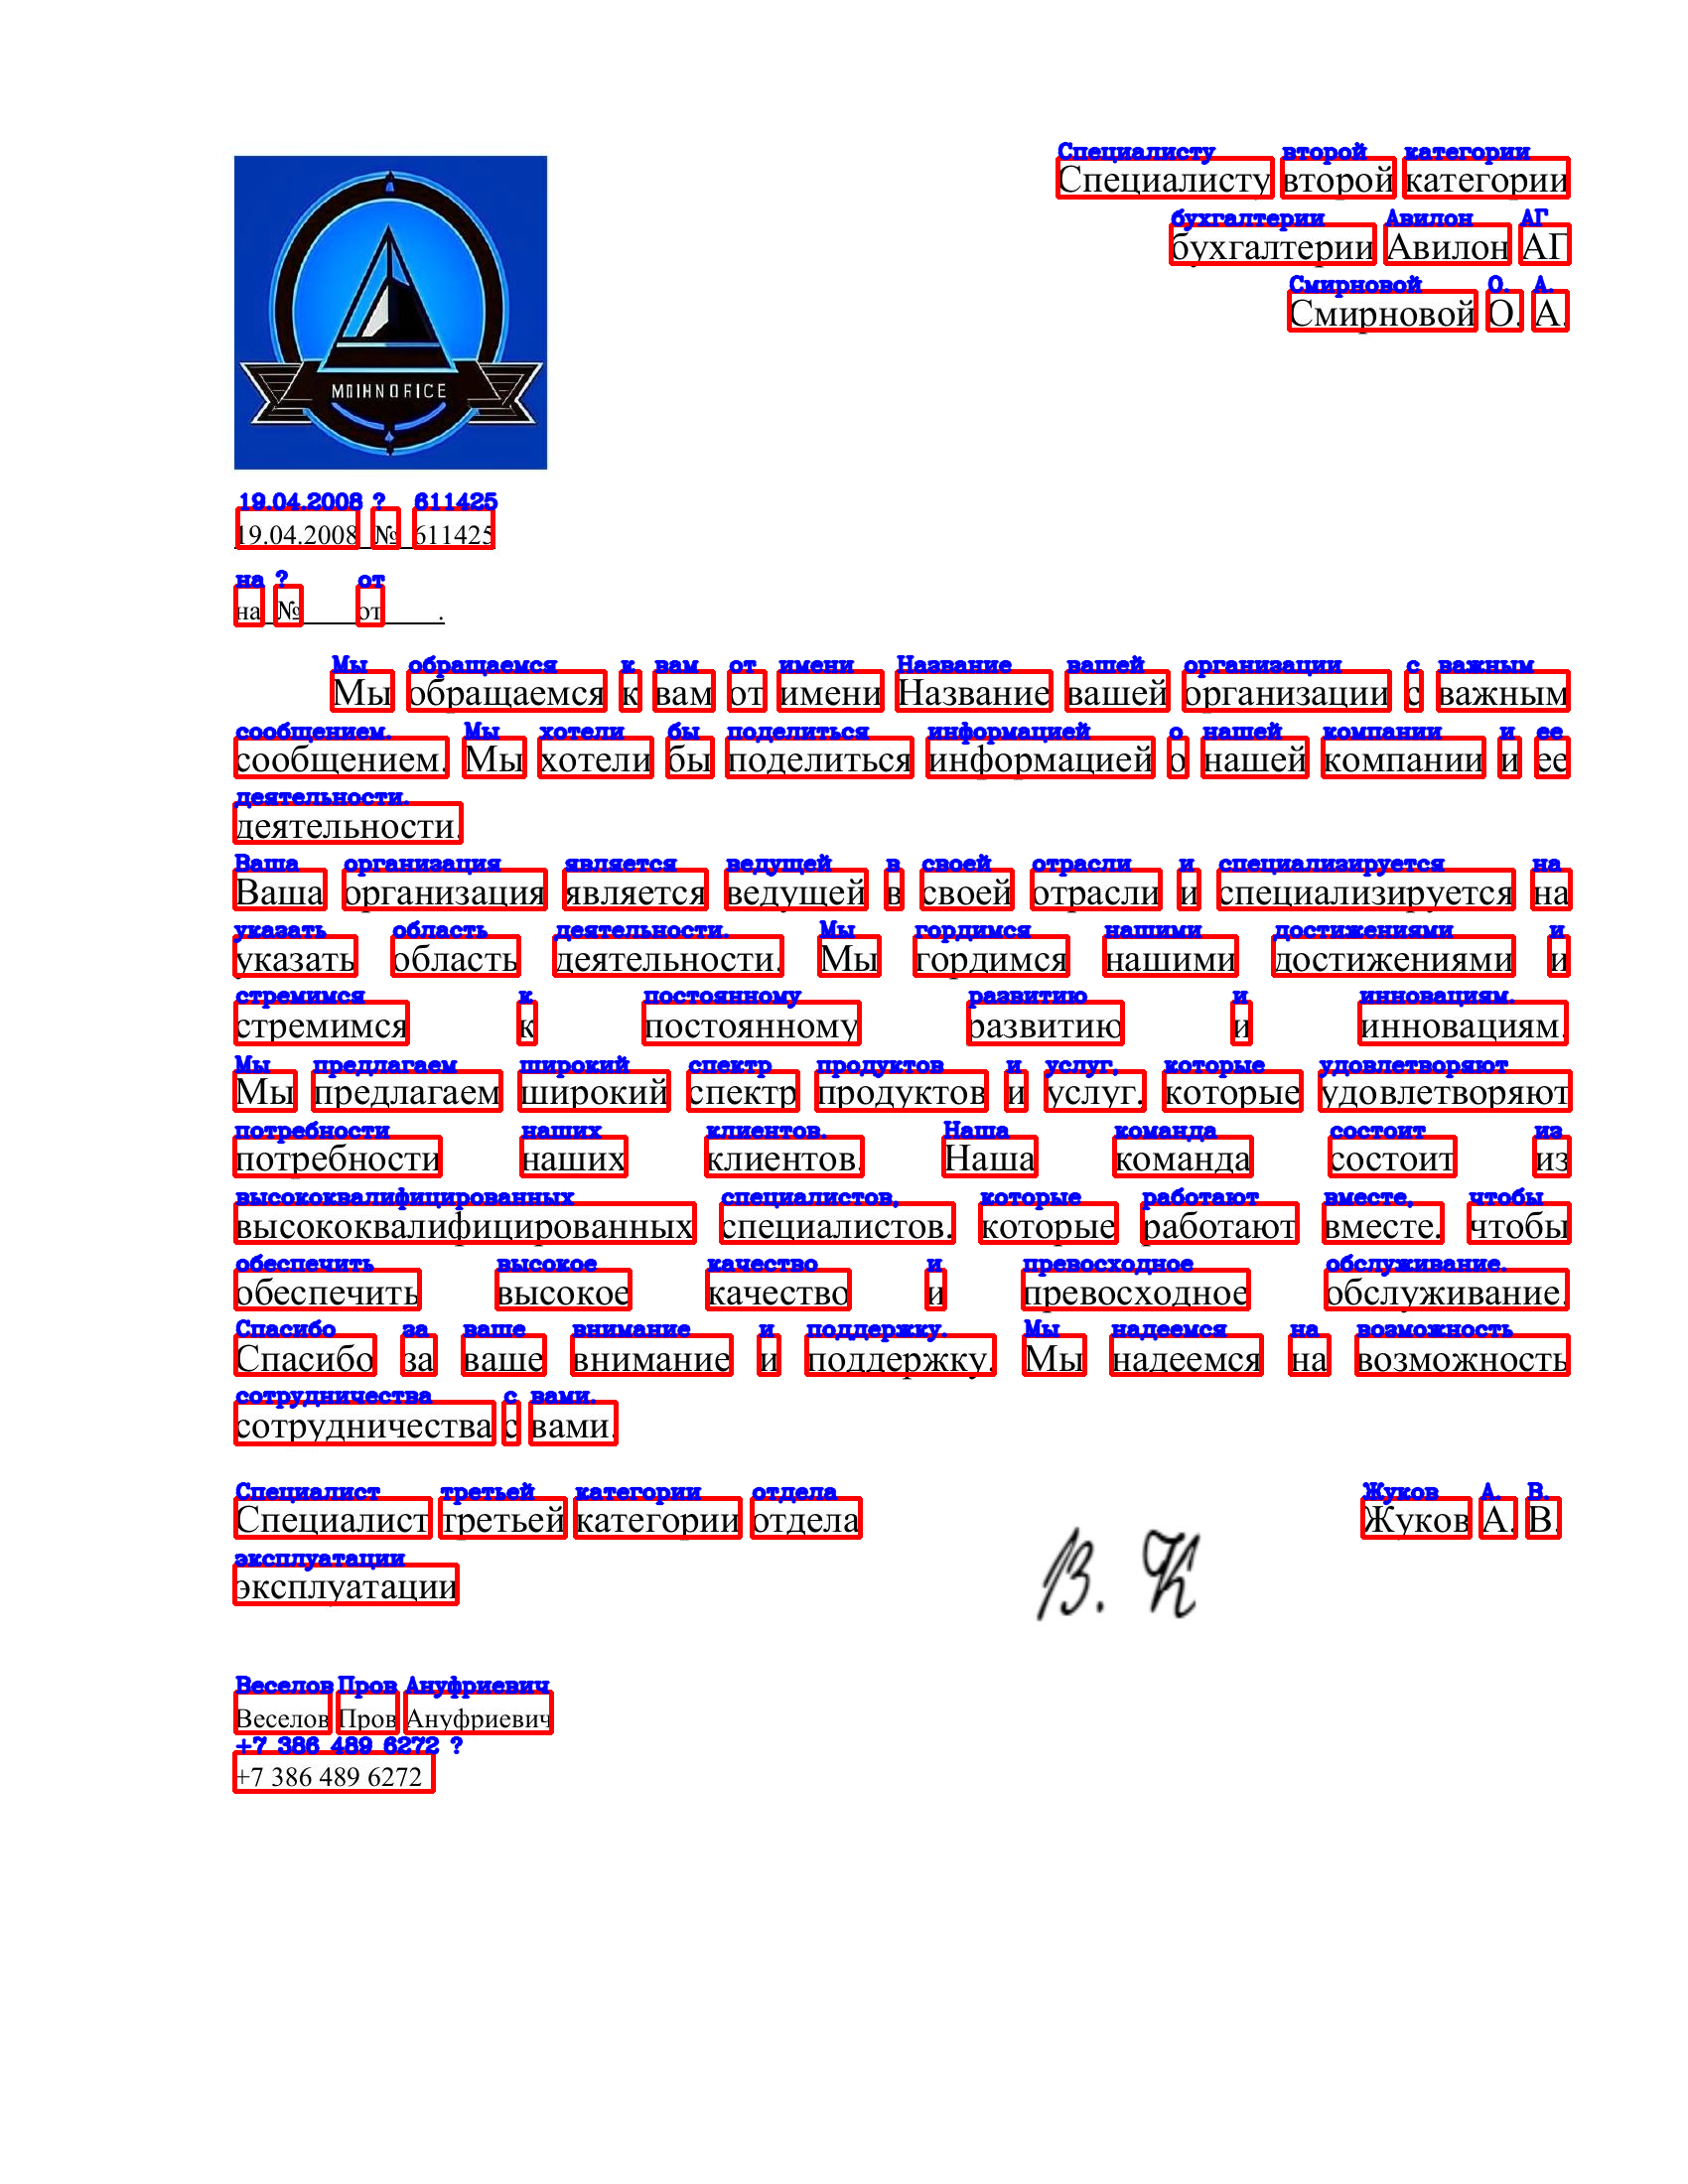

In [132]:
import cv2
n = 6
img = cv2.imread(f'letters_out/jpg/{n}.jpg')
with open(os.path.join(out_dir, 'json', f'{n}.json'), 'r') as f:
    layout = json.load(f)

for box, word in zip(layout['boxes'], layout['words']):
    img = cv2.rectangle(img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (255, 0, 0), 3)
    img = cv2.putText(img, word, (box[0][0], box[0][1]), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)

Image.fromarray(img)

In [123]:
# layout['words']
with open(os.path.join(out_dir, 'json', '2.json'), 'r') as f:
    a = json.load(f)

a['words']

['Специалисту',
 'третьей',
 'категории',
 'отдела',
 'внедрения',
 'АО',
 '«Королев',
 'Панфилова»',
 'Сафаргалиеву',
 'Т.',
 'В.',
 '03.01.2001',
 '№',
 '252985',
 'на',
 '№',
 'от',
 'Сообщаем',
 'Вам',
 'о',
 'том,',
 'что',
 '15.07.2023',
 'года',
 'в',
 '10:00',
 'состоится',
 'онлайн-\n',
 'конференция',
 '«Современные',
 'технологии',
 'и',
 'методы',
 'проектирования',
 'в',
 'машиностроении».',
 'Программа',
 'конференции:',
 '1.',
 'Введение',
 'в',
 'тему.',
 '2.',
 'Инновационные',
 'технологии',
 'проектирования',
 'машин.',
 '3.',
 'Применение',
 'современных',
 'CAD/CAM',
 'систем',
 'при',
 'проектировании',
 'механических',
 'конструкций.',
 'Для',
 'участия',
 'в',
 'конференции',
 'необходимо',
 'направить',
 'заявку',
 'на',
 'электронную',
 'почту',
 'адрес',
 'до',
 '12.07.2023',
 'года.',
 'Специалист',
 'третьей',
 'категории',
 'отдела',
 'внедрения',
 'Кириллова',
 '+7',
 '(070)',
 '902-3826',
 'Сафаргалиев',
 'Т.',
 'В. \n']

In [2]:
# f = Faker('ru_RU')
# [f.company() for _ in range(30)]
# a = 'Макаров Инк'
# any([stop_word in a.lower() for stop_word in ['инк','лтд']])

In [22]:
# morph.parse(header_sample[3])[0].inflect({'datv'}).word
# adresat.title()
# morph = pymorphy2.MorphAnalyzer(lang='ru')
# sample = ['Никитина', 'Ирина', 'Петровна']
# print(sample)
# most_likely = morph.parse(sample[1])[0]
# for candidat in morph.parse(sample[1]):
#     if 'Surn' in candidat.tag or 'nomn' in candidat.tag: # 'Surn' 'Name', 'Patr'
#         most_likely = candidat
#         if {'Surn', 'nomn'} in candidat.tag:
#             break
# most_likely
# most_likely.inflect({'sing', 'nomn'})

['Никитина', 'Ирина', 'Петровна']


Parse(word='ирина', tag=OpencorporaTag('NOUN,anim,femn,Name sing,nomn'), normal_form='ирина', score=1.0, methods_stack=((DictionaryAnalyzer(), 'ирина', 237, 0),))

# Experiments

## Comtypes

In [2]:
%%time
import sys
import os
import comtypes.client

wdFormatPDF = 17

in_file = os.path.abspath(os.path.join(out_dir, 'doc', 'letter.docx'))
out_file = os.path.abspath(os.path.join(out_dir, 'pdf', 'comtypes.pdf'))

word = comtypes.client.CreateObject('Word.Application')
doc = word.Documents.Open(in_file)
doc.SaveAs(out_file, FileFormat=wdFormatPDF)
doc.Close()
word.Quit()

# pdf2jpg.convert_pdf2jpg(out_file, os.path.join(out_dir, 'jpg', 'comtypes.jpg'), pages="ALL")

CPU times: total: 500 ms
Wall time: 3.63 s


0

In [3]:
pdf = pdfium.PdfDocument(os.path.join(out_dir, 'pdf', 'comtypes.pdf'))

n_pages = len(pdf)

for page_num in range(n_pages):
    page = pdf.get_page(page_num)
    pil_image = page.render(
        scale=1,
        rotation=0,
        crop=(0, 0, 0, 0),
        # colour=(255, 255, 255, 255),
        # annotations=True,
        # greyscale=False,
        # optimise_mode=pdfium.OptimiseMode.NONE
    ).to_pil()
    pil_image.save(os.path.join(out_dir, 'jpg', f'comtypes_{page_num}.png'))

pdf.close()

True

## Pywin32

In [4]:
%%time
import sys
import os
import win32com.client

wdFormatPDF = 17

in_file = os.path.abspath(os.path.join(out_dir, 'doc', 'letter.docx'))
out_file = os.path.abspath(os.path.join(out_dir, 'pdf', 'win32.pdf'))

word = win32com.client.Dispatch('Word.Application')
doc = word.Documents.Open(in_file)
doc.SaveAs(out_file, FileFormat=wdFormatPDF)
doc.Close()
word.Quit()

# pdf2jpg.convert_pdf2jpg(out_file, os.path.join(out_dir, 'jpg', 'win32.jpg'), pages="ALL")

CPU times: total: 31.2 ms
Wall time: 2.82 s


## Aspose.words

оставляет вотермарку

In [5]:
%%time
import aspose.words as aw

# Load word document
doc = aw.Document(os.path.join(out_dir, 'doc', 'letter.docx'))

# Save as PDF
doc.save(os.path.join(out_dir, 'pdf', 'aspose.pdf'))

# pdf2jpg.convert_pdf2jpg(os.path.join(out_dir, 'pdf', 'aspose.pdf'), os.path.join(out_dir, 'jpg', 'aspose.jpg'), pages="ALL")

CPU times: total: 2.14 s
Wall time: 3.51 s


## docx2pdf

In [6]:
%%time
from docx2pdf import convert

convert(os.path.join(out_dir, 'doc', 'letter.docx'), os.path.join(out_dir, 'pdf', 'docx2pdf.pdf'))

C:\Users\mkoltunov\Projects\letters_dataset_generator\letters_gen_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]

CPU times: total: 109 ms
Wall time: 5.05 s


In [7]:
pdf = pdfium.PdfDocument(os.path.join(out_dir, 'pdf', 'docx2pdf.pdf'))

n_pages = len(pdf)

for page_num in range(n_pages):
    page = pdf.get_page(page_num)
    pil_image = page.render(
        scale=1,
        rotation=0,
        crop=(0, 0, 0, 0),
    ).to_pil()
    pil_image.save(os.path.join(out_dir, 'jpg', f'docx2pdf_{page_num}.png'))

pdf.close()

True

## pdf2image

### Need to download a poppler https://github.com/oschwartz10612/poppler-windows/releases/

In [57]:
# need a poppler
from pdf2image import convert_from_path

images = convert_from_path(os.path.join(out_dir, 'pdf', '99.pdf'), poppler_path=r'poppler-23.11.0\Library\bin') # set your poppler path

for i in range(len(images)):
    images[i].save(os.path.join(out_dir, 'jpg', f'docx2pdf_{i}.jpg'), 'JPEG')


In [205]:
os.path.basename(os.path.join(out_dir, 'pdf', 'letter.pdf')).split('.')[0]

'letter'

# Boxes extraction

In [13]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator
import pdfminer
import os
import pandas as pd
import pdf2image
import numpy as np
import PIL
from PIL import Image
import io
from pathlib import Path # it's just my favorite way to handle files
# poppler_path=r'poppler-23.11.0\Library\bin'
# pdf path
# pdf_path ="test.pdf"
pdf_path = 'letters_out/pdf/0.pdf' #Path.cwd()/"Git From Bottom Up.pdf"


# PART 1: GET LTBOXES COORDINATES IN THE IMAGE ----------------------
# Open a PDF file.
fp = open(pdf_path, 'rb')

# Create a PDF parser object associated with the file object.
parser = PDFParser(fp)

# Create a PDF document object that stores the document structure.
# Password for initialization as 2nd parameter
document = PDFDocument(parser)

# Check if the document allows text extraction. If not, abort.
if not document.is_extractable:
    raise PDFTextExtractionNotAllowed

# Create a PDF resource manager object that stores shared resources.
rsrcmgr = PDFResourceManager()

# Create a PDF device object.
device = PDFDevice(rsrcmgr)

# BEGIN LAYOUT ANALYSIS
# Set parameters for analysis.
laparams = LAParams()

# Create a PDF page aggregator object.
device = PDFPageAggregator(rsrcmgr, laparams=laparams)

# Create a PDF interpreter object.
interpreter = PDFPageInterpreter(rsrcmgr, device)


# here is where i stored the data
boxes_line_data = []
page_sizes = []

def parse_obj(lt_objs, verbose = 0):
    # loop over the object list
    for obj in lt_objs:
        # if it's a textbox, print text and location
        if isinstance(obj, pdfminer.layout.LTTextBoxHorizontal):
            if verbose >0:
                print("%6d, %6d, %s" % (obj.bbox[0], obj.bbox[1], obj.get_text()))
            data_dict = {
                "startX":round(obj.bbox[0]),"startY":round(obj.bbox[1]),
                "endX":round(obj.bbox[2]),"endY":round(obj.bbox[3]),
                "text":obj.get_text()}
            boxes_line_data.append(data_dict)
        # if it's a container, recurse
        elif isinstance(obj, pdfminer.layout.LTFigure):
            parse_obj(obj._objs)

# loop over all pages in the document
for page in PDFPage.create_pages(document):
    # read the page into a layout object
    interpreter.process_page(page)
    layout = device.get_result()
    # extract text from this object
    parse_obj(layout._objs)
    mediabox = page.mediabox
    mediabox_data = {"height":mediabox[-1], "width":mediabox[-2]}
    page_sizes.append(mediabox_data)

# PART 2: NOW GET PAGE TO IMAGE -------------------------------------
firstpage_size = page_sizes[0]
firstpage_image = pdf2image.convert_from_path(pdf_path, poppler_path=r'poppler-23.11.0\Library\bin')[0] # without 'size=...'
#show first page with the right size (at least the one that pdfminer says)
# firstpage_image.show()
# firstpage_image.save("firstpage.png")

# the magic numbers
dpi = 200/72
vertical_shift = 5 # I don't know, but it's need to shift a bit
page_height = int(firstpage_size["height"] * dpi)

# loop through boxes (we'll process only first page for now)
for i, _ in enumerate(boxes_line_data):

    #first box data
    startX, startY, endX, endY, text = boxes_line_data[i].values()

    # correction PDF --> PIL
    startY = page_height - int(startY * dpi) - vertical_shift
    endY   = page_height - int(endY   * dpi) - vertical_shift
    startX = int(startX * dpi)
    endX   = int(endX   * dpi)
    startY, endY = endY, startY 

    # turn image into array
    image_array = np.array(firstpage_image)
    # get cropped box
    box = image_array[startY:endY,startX:endX,:]
    convert2pil_image = PIL.Image.fromarray(box)
    boxes = get_word_boxes(box)
    #show cropped box image
    # convert2pil_image.show()
    png = "crop_" + str(i) + ".png"
    # convert2pil_image.save(png)
    #print this does not match with the text, means there's an error
    print(text.split(' '))
    print(boxes)

['', 'ООО', '«Щукина', 'Меркушева»', '\n']
[11, 93, 105, 261, 270, 480]
['Симонову', 'Н.', 'С.', '\n']
[171, 179, 214, 228, 259]
['28.07.2017', '№', '008049', '', '\n']
[125, 132, 158, 166, 247]
['на', '№', '', '', '', '', '', '', '', 'от', '', '', '', '', '', '', '', '.', '\n']
[204]
['Уважаемый', 'Симонов', 'Н.', 'С.!', '\n']
[196, 208, 356, 366, 401, 414, 446, 453, 457]
['Мы', '', 'обращаемся', '', 'к', '', 'вам', '', 'от', '', 'имени', '', 'Название', '', 'вашей', '', 'организации', '', 'с', '', 'важным', '\n']
[62, 78, 277, 292, 311, 325, 385, 401, 437, 451, 555, 570, 725, 740, 843, 859, 1066, 1083, 1098, 1114, 1246]
['сообщением.', '', 'Мы', '', 'хотели', '', 'бы', '', 'поделиться', '', 'информацией', '', 'о', '', 'нашей', '', 'компании', '', 'и', '', 'ее', '\n']
[214, 231, 292, 307, 420, 436, 481, 496, 683, 698, 925, 941, 959, 975, 1080, 1096, 1258, 1274, 1294, 1311, 1343]
['деятельности.', '\n']
[228]
['Ваша', '', 'организация', '', 'является', '', 'ведущей', '', 'в', '', 'свое

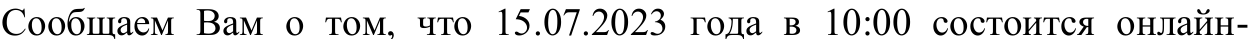

In [83]:
# boxes_data
img = Image.open('crop_5.png')
img

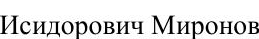

In [72]:
img = Image.open('letters_out/jpg/0.jpg')
img_array = np.array(img)
box = layout['boxes'][-5]
img_array = img_array[box[0][1]:box[1][1], box[0][0]:box[1][0]]
# img_array = img_array[:, 145:155, :]
Image.fromarray(img_array)

In [73]:
img_array[:, 145:155].mean(axis=(0, 2))
# img_array.shape

array([253.07692308, 253.94871795, 254.02564103, 254.33333333,
       253.33333333, 254.20512821, 250.15384615, 245.87179487,
       239.23076923, 139.94871795])

In [74]:
get_word_boxes(img_array, white_px_count=3)

[0, 144, 151, 258]

In [91]:
# img_array = np.array(img)
px_sum = img_array.mean(axis=(0, 2))
# len(px_sum)
word_borders = []
white_count = 0
for i, col in enumerate(px_sum):
    if col == 255:
        white_count += 1
    else:
        if i - white_count <= 0:
            word_borders.append(i)
        elif white_count > 5:
            word_borders.append(i - white_count)
            word_borders.append(i)
        white_count = 0
    if i == len(px_sum) - 1:
        word_borders.append(i - white_count)
word_borders

[2,
 174,
 196,
 263,
 286,
 304,
 325,
 394,
 417,
 472,
 498,
 666,
 690,
 763,
 783,
 801,
 827,
 911,
 933,
 1095,
 1117,
 1247]

In [88]:
# px_sum

In [ ]:
def get_word_boxes(img_arr, white_px_count=5):
    px_sum = img_arr.mean(axis=(0, 2))
    # len(px_sum)
    word_borders = []
    white_count = 0
    for i, col in enumerate(px_sum):
        if col == 255:
            white_count += 1
        else:
            if white_count > white_px_count:
                if i - white_count <= 0:
                    word_borders.append(i)
                else:
                    word_borders.append(i - white_count)
                    word_borders.append(i)
            white_count = 0
        if i == len(px_sum) - 1:
            word_borders.append(i - white_count)

    return word_boxes

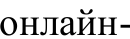

In [103]:
n_word = 20 # :6 (0,1) (2,3) (4, 5)
w = img_array[:, word_borders[n_word]:word_borders[n_word+1], :]
pil_w = Image.fromarray(w)
pil_w

In [66]:
px_sum[0] == 255

True